# 1. Import Dependencies and Data

In [ ]:
# !pip install tensorflow-gpu==2.10.0 matplotlib tensorflow-datasets ipywidgets tensorflow==2.10.0

In [10]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.2.0
certifi                      2022.9.24
charset-normalizer           2.1.1
colorama                     0.4.6
cycler                       0.11.0
debugpy                      1.6.4
decorator                    5.1.1
dill                         0.3.6
entrypoints                  0.4
etils                        0.9.0
flatbuffers                  22.12.6
fonttools                    4.38.0
gast                         0.4.0
google-auth                  2.15.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
googleapis-common-protos     1.57.0
grpcio                       1.51.1
h5py                         3.7.0
idna                         3.4
importlib-metadata           5.1.0
importlib-resources          5.10.1
ipykernel                    6.16.2
ipyth

In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [5]:
# Use the Tensorflow Dataset API to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\rober\tensorflow_datasets\fashion_mnist\3.0.1.incompleteC8JA6N\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\rober\tensorflow_datasets\fashion_mnist\3.0.1.incompleteC8JA6N\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\rober\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [14]:
import numpy as np

In [8]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [10]:
# Getting data out of the pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 59],
         [ 77],
         [ 58],
         [ 56],
         [ 58],
         [ 57],
         [ 65],
         [ 89],
         [  2],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [245],
         [213],
         [199],
         [192],
         [188],
         [189],
         [184],
         [226],
         [ 90],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [14]:
dataiterator.next()['image'].shape

(28, 28, 1)

In [15]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

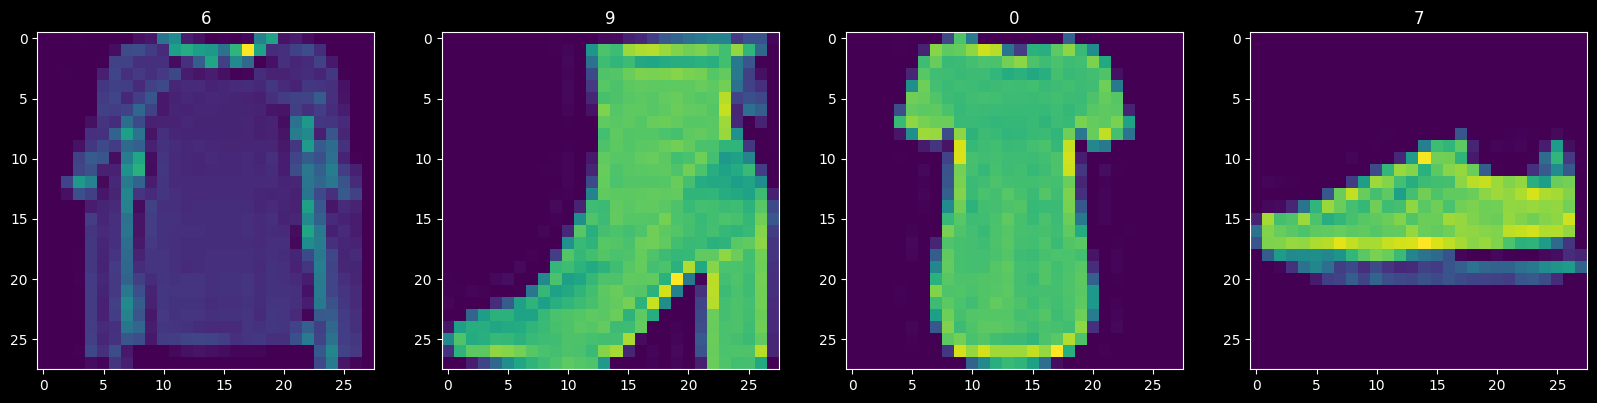

In [16]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Loop for times and get images
for idx in range(4):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])


In [5]:
def scale_images(data):
  image = data['image']
  return image / 255

In [6]:
ds = tfds.load('fashion_mnist', split='train') # Reload the dataset
ds = ds.map(scale_images) # Running the datset through the scale_images preprocessing step
ds = ds.cache() # Cache the dataset for that batch
ds = ds.shuffle(60000) # shuffle it up 
ds = ds.batch(128) # Batch into 128 images per sample
ds = ds.prefetch(64) # Reduces the likeihood of bottlenecking

In [7]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Newtwork

### 3.1 Import Modelling Components

In [8]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [9]:
def build_generator():
  model = Sequential()
  # Takes in random values and reshapes it to 7x7x128
  # Begining of a generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7, 7, 128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Down sampling block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Down sampling block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv Layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

  return model

In [10]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
img = generator.predict(np.random.randn(4, 128, 1))


1/1 [==============================] - 28s 28s/step


In [16]:
img.shape

(4, 28, 28, 1)

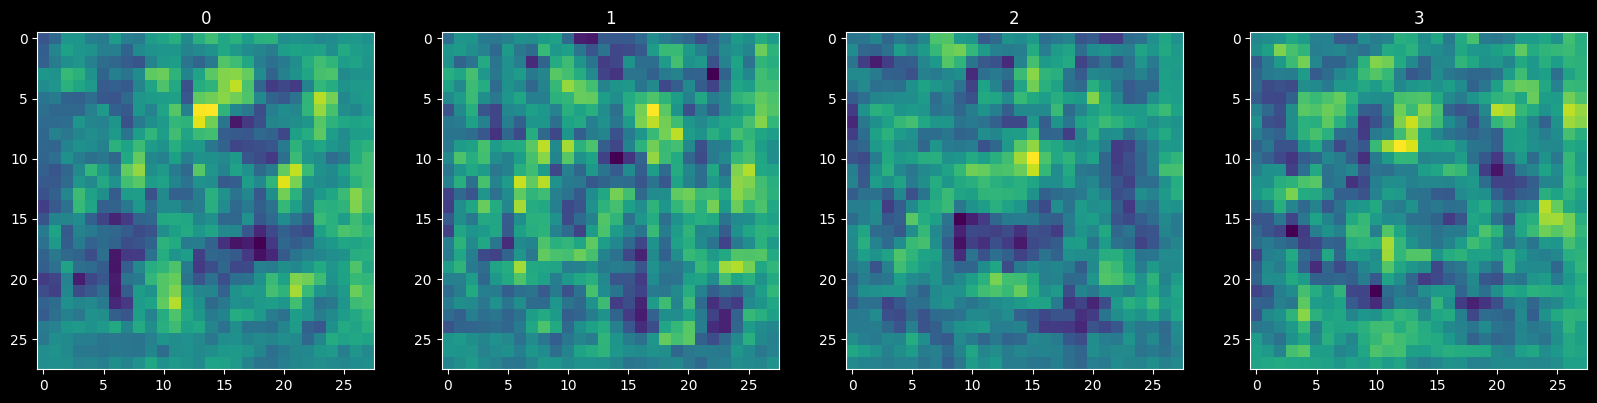

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img  in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [18]:
def build_discriminator():
  model = Sequential()
  
  # First Conv Block
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second Conv Block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third Conv Block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth Conv Block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass dense Layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))


  return model

In [19]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 1s 733ms/step


array([[0.49664277]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy

In [22]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryFocalCrossentropy()
d_loss = BinaryFocalCrossentropy()

### 4.2 Build Subclassed Model

In [23]:
from tensorflow.keras.models import Model

In [12]:
tf.random.normal((6, 28,28, 1))

<tf.Tensor: shape=(6, 28, 28, 1), dtype=float32, numpy=
array([[[[-0.22664264],
         [-1.4714994 ],
         [-1.324957  ],
         ...,
         [-0.23008542],
         [-1.579822  ],
         [-2.1548874 ]],

        [[-1.0979421 ],
         [ 0.8713945 ],
         [ 0.2157889 ],
         ...,
         [-0.82939386],
         [ 0.501355  ],
         [-2.5557096 ]],

        [[ 1.0225646 ],
         [-0.04094396],
         [ 0.9186562 ],
         ...,
         [ 1.6643004 ],
         [-0.31211528],
         [ 0.8438391 ]],

        ...,

        [[-1.1740117 ],
         [-0.01518351],
         [ 0.8601822 ],
         ...,
         [-1.6549555 ],
         [-1.330497  ],
         [-1.0392072 ]],

        [[-0.6656074 ],
         [-1.9483736 ],
         [-0.86773574],
         ...,
         [-1.8597181 ],
         [ 0.32180703],
         [-0.09182166]],

        [[ 1.7125549 ],
         [ 0.9110173 ],
         [-0.91592306],
         ...,
         [-1.673306  ],
         [-0.5778662

In [41]:
class FashionGAM(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    
    # Create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, d_loss, g_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    # Create attributes for Losses and Optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels for real and fakes images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add some noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # Calculate Loss - BINARYCROSS
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)
    
    # Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128, 128,1)), training=True)

      # Create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Calculate Loss - trick to traning to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {'d_loss': total_d_loss, 'g_loss': total_g_loss}

In [42]:
fashiongan = FashionGAM(generator, discriminator)

In [43]:
fashiongan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [38]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [39]:
class ModelMonitor(Callback):
  def __init__(self, num_img =3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim
  
  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train

In [45]:
# Recommend 2000 epocs
hist = fashiongan.fit(ds, epochs=3, callbacks=[ModelMonitor()])

Epoch 1/3
  6/469 [..............................] - ETA: 1:43 - d_loss: 0.1688 - g_loss: 0.1710WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1022s vs `on_train_batch_end` time: 0.1227s). Check your callbacks.


469/469 [==============================] - 114s 242ms/step - d_loss: 0.1649 - g_loss: 0.1718
Epoch 2/3
469/469 [==============================] - 116s 246ms/step - d_loss: 0.1558 - g_loss: 0.1237
Epoch 3/3
469/469 [==============================] - 116s 248ms/step - d_loss: 0.1279 - g_loss: 0.0734


### 4.4 Review Performance

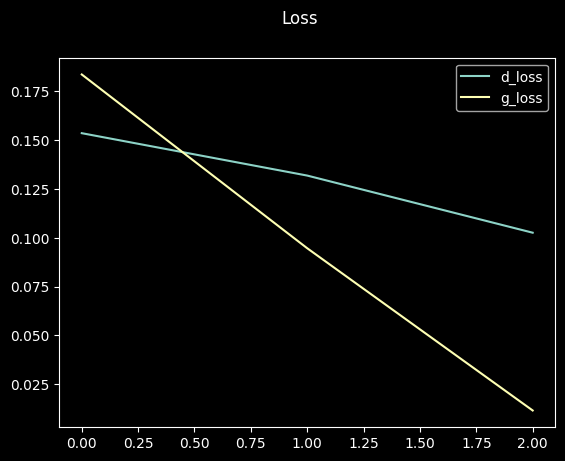

In [47]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [48]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
imgs

1/1 [==============================] - 10s 10s/step


array([[[[1.00000000e+00],
         [2.82646869e-15],
         [0.00000000e+00],
         ...,
         [1.00000000e+00],
         [1.00000000e+00],
         [1.00000000e+00]],

        [[1.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [1.00000000e+00],
         [1.00000000e+00],
         [1.00000000e+00]],

        [[1.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [1.00000000e+00],
         [1.00000000e+00],
         [1.00000000e+00]],

        ...,

        [[1.00000000e+00],
         [2.82788805e-33],
         [0.00000000e+00],
         ...,
         [0.00000000e+00],
         [0.00000000e+00],
         [1.17913207e-17]],

        [[1.00000000e+00],
         [1.00000000e+00],
         [7.56079643e-10],
         ...,
         [0.00000000e+00],
         [4.77184079e-31],
         [5.24764433e-12]],

        [[1.00000000e+00],
         [1.00000000e+00],
         [1.00000000e+00],
         ...,
 

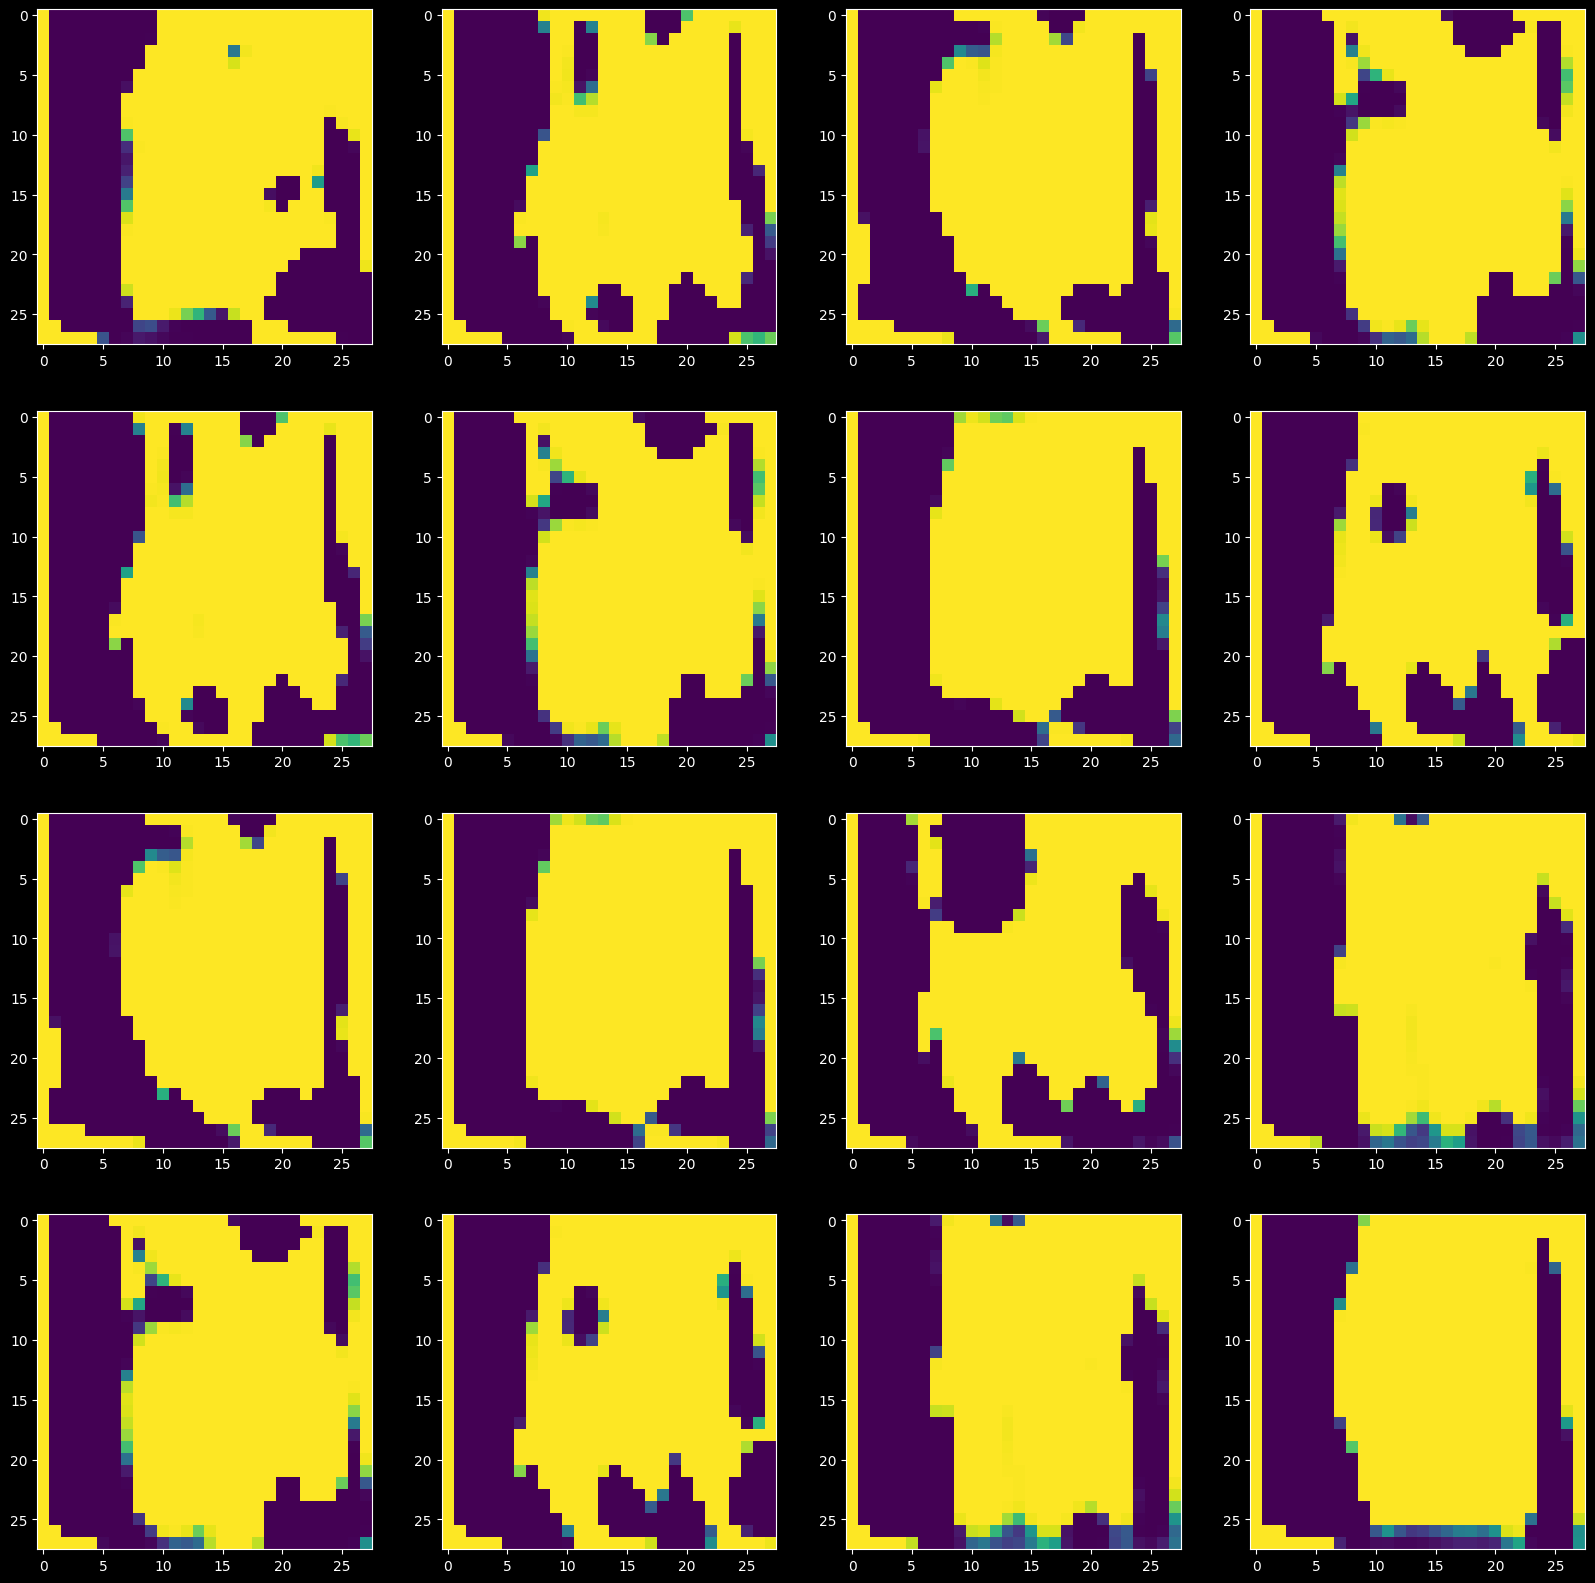

In [49]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1) -1])

### 5.2 Save the Model

In [50]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')